In [1]:
import copy
import sys
from typing import Any

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import numpy.typing as npt
import pandas as pd
from matplotlib import cm
from matplotlib.axes import Axes
from matplotlib.colors import Normalize
from matplotlib.figure import Figure
from matplotlib.gridspec import GridSpec

sys.path.append("..")
from NGS.data import add_missing, add_noise, preprocess
from NGS.hyperparameter import HyperParameter
from path import DATA_DIR, RESULT_DIR

plt.rcParams.update(
    {
        "font.family": "FreeSerif",
        "mathtext.default": "regular",
        "text.usetex": True,
        "text.latex.preamble": r"\usepackage{amsmath, amssymb}",
        "font.size": 20,
        "axes.titlesize": 20,
        "axes.labelsize": 20,
        "legend.fontsize": 20,
        "xtick.labelsize": 15,
        "ytick.labelsize": 15,
    }
)


In [2]:
dataset = "heat_train"
missing, noise = 0.1, 0.001

# True trajectories
df = pd.read_pickle(DATA_DIR / f"{dataset}.pkl")
train, _ = preprocess(df, val_ratio=0.2)
true_trajectories = train["trajectories"]
eval_times = [np.insert(np.cumsum(dt), 0, 0.0) for dt in train["dts"]]

# Pred trajectories
exp_id = f"heat_p{missing}_s{noise}"
result_dir = RESULT_DIR / exp_id
hp = HyperParameter.from_yaml(result_dir / "hyperparameter.yaml")
assert hp.missing == missing
assert hp.noise == noise
pred_df = pd.read_pickle(result_dir / f"{dataset}.pkl")
pred_trajectories = pred_df["trajectories"]

# Incomplete trajectories
rng = np.random.default_rng(hp.seed)
seed_missing, seed_noise = rng.integers(42, size=(2,))
incomplete_train = copy.deepcopy(train)
add_missing(incomplete_train, missing, seed_missing, 2)
add_noise(incomplete_train, noise, seed_noise)
is_missings = incomplete_train["is_missings"]

# DOP853 nfevs/runtimes
df_int = pd.read_pickle(DATA_DIR / "heat_test_int.pkl")
df_ext = pd.read_pickle(DATA_DIR / "heat_test_ext.pkl")
dop853_nfevs = {"int": df_int.nfev.values, "ext": df_ext.nfev.values}
dop853_runtimes = {"int": df_int.runtime.values, "ext": df_ext.runtime.values}

# NGS nfevs/runtimes
df_int = pd.read_pickle(result_dir / "heat_test_int.pkl")
df_ext = pd.read_pickle(result_dir / "heat_test_ext.pkl")
ngs_nfevs = {"int": df_int.nfev.values, "ext": df_ext.nfev.values}
ngs_runtimes = {"int": df_int.runtime.values, "ext": df_ext.runtime.values}

### Single sample trajectory

In [3]:
sample_idx = 543

graph = df.graph[sample_idx]
is_missing = is_missings[sample_idx]
true_trajectory = true_trajectories[sample_idx].squeeze()
pred_trajectory = pred_trajectories[sample_idx].squeeze()
eval_time = eval_times[sample_idx]

# Extract giant connected components
gcc_nodes = np.array(
    list(sorted(nx.connected_components(graph), key=len, reverse=True)[0]),
    dtype=np.int64,
)
gcc = graph.subgraph(gcc_nodes)
pos = nx.spring_layout(gcc, seed=38, k=2.0 / np.sqrt(len(gcc_nodes)))
dissipation = np.stack(
    list(nx.get_edge_attributes(gcc, "edge_attr").values())
).squeeze()
missing_gcc_nodes = np.array([n for n in gcc_nodes if is_missing[n]])
nonmissing_gcc_nodes = np.setdiff1d(gcc_nodes, missing_gcc_nodes)

# Plot settings
cmap, vmin, vmax = "coolwarm", 0.0, 1.0
state_kwargs: dict[str, Any] = dict(
    pos=pos, node_size=50, edgecolors="k", linewidths=0.5
)

def plot_state(ax: Axes, state: npt.NDArray[np.float32]) -> None:
    nx.draw_networkx(
        gcc,
        ax=ax,
        with_labels=False,
        node_color=state[nonmissing_gcc_nodes],
        nodelist=nonmissing_gcc_nodes,
        width=0.5 * np.exp(dissipation),
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        **state_kwargs,
    )
    nx.draw_networkx_nodes(
        gcc,
        ax=ax,
        node_color=state[missing_gcc_nodes],  # type:ignore
        nodelist=missing_gcc_nodes,
        node_shape="s",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        **state_kwargs,
    )


def shrink_cbar(cax, shrink: float):
    b = cax.get_position()
    pad = 0.5 * (1.0 -shrink) * b.height
    b.y0 += pad
    b.y1 -= pad
    cax.set_position(b)

def plot_cbar(fig: Figure, cax: Axes, shrink: float = 0.8) -> None:
    sm = cm.ScalarMappable(Normalize(vmin, vmax), cmap)
    fig.colorbar(sm, cax=cax, location="right")
    shrink_cbar(cax, shrink)


### Errors

In [4]:
error = pred_trajectory - true_trajectory


def plot_error(ax: Axes) -> None:
    ax.boxplot(
        error.squeeze().T,
        positions=eval_time,
        manage_ticks=False,
        notch=True,
        widths=0.01,
        capwidths=0.01,
        medianprops={"color": "g"},
        flierprops={"marker": "o", "markerfacecolor": "none", "markeredgecolor": "g"},
    )


def plot_rect(ax: Axes, steps: list[int]) -> None:
    width = 0.02
    y_min, y_max = ax.get_ylim()
    y_min += 5e-5
    y_max -= 5e-5
    rect_height = y_max - y_min

    for step in steps:
        x_mid = eval_time[step].item()
        rect = patches.Rectangle(
            xy=(x_mid - 0.5 * width, y_min),
            height=rect_height,
            width=width,
            linewidth=2,
            edgecolor="r",
            facecolor="none",
        )
        ax.add_patch(rect)

### Efficiency

In [5]:
# Plot settings
width = 0.15
ngs_locations = np.array([0.1, 0.6])
dop853_locations = ngs_locations + width
bar_kwargs = {"width": width, "capsize": 10, "align": "edge"}

def plot_efficiency(
    ax: Axes,
    ngs: dict[str, npt.NDArray[np.float64]],
    dop853: dict[str, npt.NDArray[np.float64]],
    colors: tuple[str, str],
) -> None:
    def zero_to_none(xs: list[float]) -> list[float] | None:
        return None if all(x == 0.0 for x in xs) else xs

    ax.bar(
        ngs_locations,
        [ngs["int"].mean(), ngs["ext"].mean()],
        yerr=zero_to_none(
            [
                1.96 * ngs["int"].std() / np.sqrt(len(ngs["int"])),
                1.96 * ngs["ext"].std() / np.sqrt(len(ngs["ext"])),
            ]
        ),
        color=colors[0],
        label="NGS",
        **bar_kwargs
    )
    ax.bar(
        dop853_locations,
        [dop853["int"].mean(), dop853["ext"].mean()],
        yerr=[
            1.96 * dop853["int"].std() / np.sqrt(len(dop853["int"])),
            1.96 * dop853["ext"].std() / np.sqrt(len(dop853["ext"])),
        ],
        color=colors[1],
        label="DOP853",
        **bar_kwargs
    )

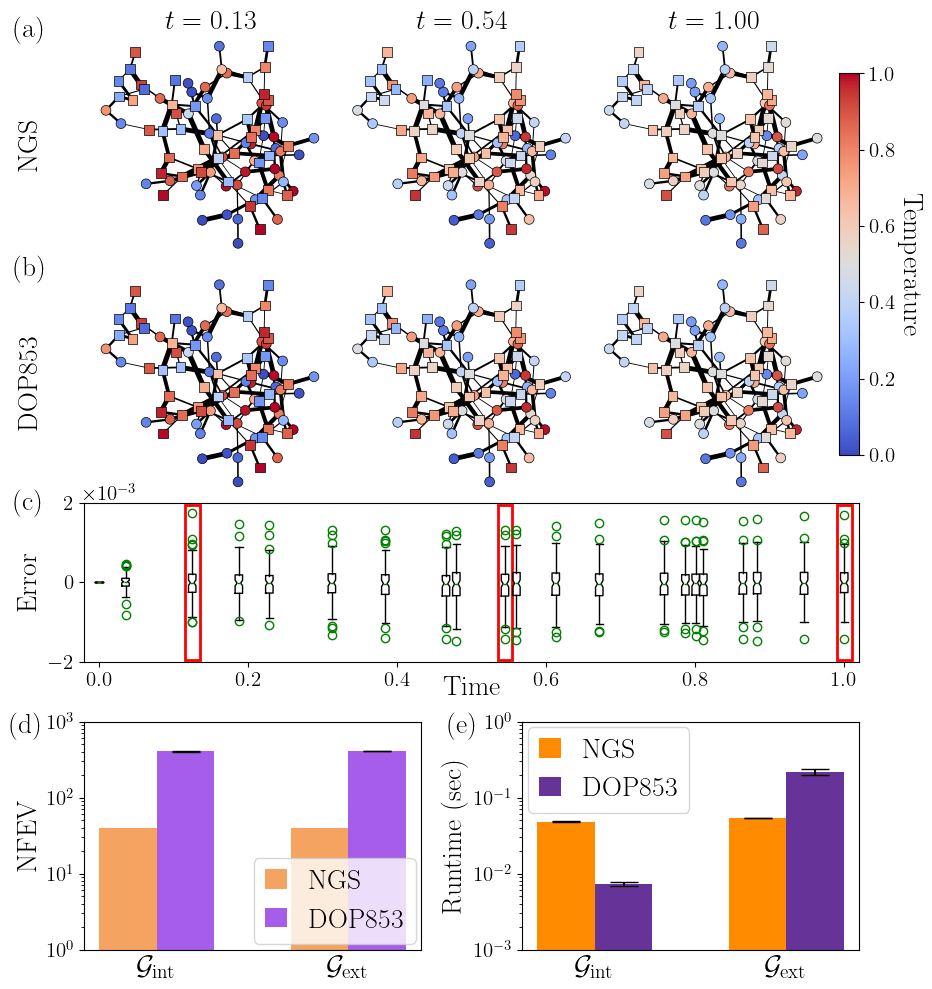

In [6]:
fig = plt.figure(figsize=(10, 12))
gs1 = GridSpec(
    3,
    4,
    hspace=0.0,
    wspace=0.0,
    height_ratios=[1.5, 1.5, 1],
    width_ratios=[1.0, 1.0, 1.0, 0.08],
    bottom=0.35,
)
gs2 = GridSpec(1, 2, top=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs1[0, 0], frameon=False)
ax2 = fig.add_subplot(gs1[0, 1], frameon=False)
ax3 = fig.add_subplot(gs1[0, 2], frameon=False)
ax4 = fig.add_subplot(gs1[1, 0], frameon=False)
ax5 = fig.add_subplot(gs1[1, 1], frameon=False)
ax6 = fig.add_subplot(gs1[1, 2], frameon=False)
ax7 = fig.add_subplot(gs1[2, :])
cax = fig.add_subplot(gs1[:2, 3])

ax8 = fig.add_subplot(gs2[0, 0])
ax9 = fig.add_subplot(gs2[0, 1])

steps = [2, 9, 20]

# NGS/DOP853 states
for ax, step in zip([ax1, ax2, ax3], steps):
    plot_state(ax, pred_trajectory[step])
for ax, step in zip([ax4, ax5, ax6], steps):
    plot_state(ax, true_trajectory[step])
# Color bars
plot_cbar(fig, cax, shrink=0.8)

# Error plots with square patches
plot_error(ax7)
ax7.set_yticks([-2e-3, 0.0, 2e-3])
_, y_max = ax7.get_ylim()
ax7.set_ylim(-y_max, y_max)
plot_rect(ax7, steps)

# Efficiency bars
plot_efficiency(ax8, ngs_nfevs, dop853_nfevs, ("sandybrown", "#A65DE9"))
plot_efficiency(ax9, ngs_runtimes, dop853_runtimes, ("darkorange", "rebeccapurple"))

# Title
for ax, step in zip([ax1, ax2, ax3], steps):
    ax.set_title("$t=" + f"{eval_time[step]:.2f}" + "$", y=0.95)

# Labels
ax1.set_ylabel("NGS", labelpad=30.0)
ax4.set_ylabel("DOP853", labelpad=30.0)
cax.set_ylabel("Temperature", rotation=-90, labelpad=20)
ax7.set_xlabel("Time", labelpad=-10)
ax7.set_ylabel("Error", labelpad=5)
ax8.set_ylabel("NFEV")
ax9.set_ylabel("Runtime (sec)")

# Ticks
ax7.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))
ax7.set_xlim(-0.02, 1.02)
for ax in [ax8, ax9]:
    ax.set_xticks(dop853_locations)
    ax.set_xticklabels([r"$\mathcal{G}_\text{int}$", r"$\mathcal{G}_\text{ext}$"])
    ax.tick_params(axis="x", length=0, labelsize=20)

# Text
ax1.text(-0.28, 0.95, "(a)", transform=ax1.transAxes)
ax4.text(-0.28, 0.95, "(b)", transform=ax4.transAxes)
ax7.text(-0.09, 0.95, "(c)", transform=ax7.transAxes)
ax8.text(-0.22, 0.95, "(d)", transform=ax8.transAxes)
ax9.text(-0.22, 0.95, "(e)", transform=ax9.transAxes)

# Scales and limits
ax8.set_yscale("log")
ax9.set_yscale("log")
ax8.set_ylim(1e0, 1e3)
ax9.set_ylim(1e-3, 1e0)

# Legends
ax8.legend(handlelength=0.8, borderaxespad=0.2, loc="lower right")
ax9.legend(handlelength=0.8, borderaxespad=0.2, loc="upper left")

# fig.savefig("fig2.pdf", bbox_inches="tight")
fig.show()